In [1]:
import os
from typing import List, Optional

from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import colorcet as cc


from cuml.cluster import KMeans as cuKMeans
from sklearn.cluster import KMeans


def load_result(dir_path, ensemble_size=5, skip=None):
    if skip is None:
        skip = []
    elif isinstance(skip, int):
        skip = [skip]
    pred_res_list = []
    for i in range(ensemble_size):
        if i+1 in skip:
            continue
        pred_res_path = dir_path + f"final_result_{i+1}.csv"
        print("loading", pred_res_path)
        pred_res = pd.read_csv(pred_res_path)
        # change pred_result to pred_result_1, pred_result_2, ...
        pred_res.columns = [f"{col}_{i+1}" if col != "smi_name" else col for col in pred_res.columns]
        pred_res_list.append(pred_res)
    return pred_res_list
        


embedding_dir = "/home/sdl/SDL-LNP/model/evaluation/notebooks/"
data_dir = "/home/sdl/SDL-LNP/model/serverless/test/"
tested_smiles_file = "/home/sdl/control_dashboard/info_server/SDL-LNP/model/evaluation/notebooks/exp1030_export.csv"  # NOTE: change this to the newest file
print("Existing tested smiles in", tested_smiles_file)


embeddings_path = embedding_dir + "test_result_representation.npz"


pred_res_list = load_result(data_dir)
pred_res = pd.concat(pred_res_list, axis=1, join="outer")
with np.load(embeddings_path) as data:
    embeddings = data["arr_0"]
    
# keep only one smi_name column
pred_res = pred_res.loc[:, ~pred_res.columns.duplicated()]
mean_pred_res = pred_res.groupby("smi_name").mean()
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()

MAPPING_PATH = "/home/sdl/SDL-LNP/model/data_process/220k_library.csv"
mapping_df = pd.read_csv(MAPPING_PATH)
NAME_SMI_PATH = "/home/sdl/SDL-LNP/mapping_table/General_mapping_sampler.csv"
name_smi_df = pd.read_csv(NAME_SMI_PATH)


mapping_df["A_name"] = mapping_df["A_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["B_name"] = mapping_df["B_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["C_name"] = mapping_df["C_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["D_name"] = mapping_df["D_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])


mean_pred_res = pred_res.groupby("smi_name").mean()  # mean over different conformations
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()


Existing tested smiles in /home/sdl/control_dashboard/info_server/SDL-LNP/model/evaluation/notebooks/exp1030_export.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_1.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_2.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_3.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_4.csv


In [2]:
# read in already tested smiles from existing experiment results
# will ensure new candidates proposed are not duplicates
tested_smiles = pd.read_csv(tested_smiles_file)["smiles"].values.tolist()
print("Number of already tested smiles:", len(tested_smiles))

Number of already tested smiles: 1469


# step 1

In [3]:
predictive_variance = mean_pred_res.var(axis=1)

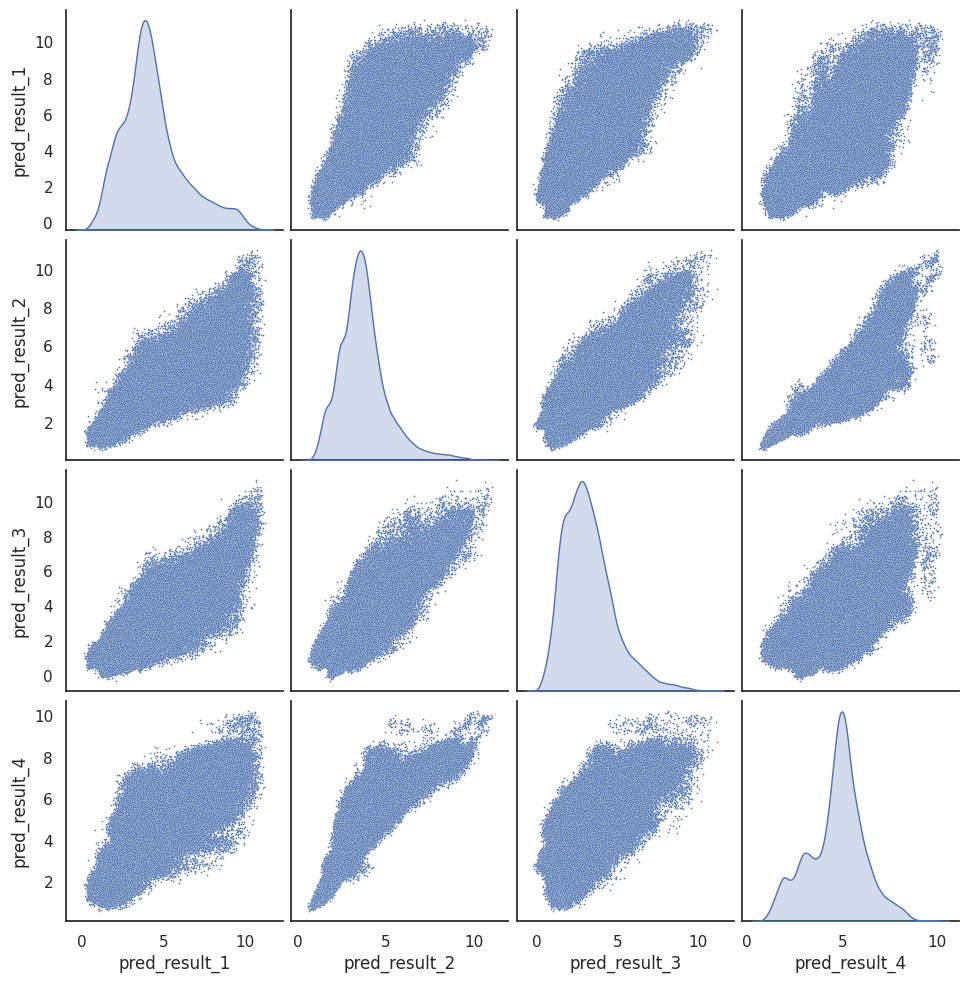

In [4]:
# plot grid of df
sns.set_theme(style="white")
df = mean_pred_res
sns.pairplot(df, diag_kind="kde", plot_kws={"s": 1.5})

In [5]:
def count_components(structures):
    res_list = []
    # structures is a list of smiles
    idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
    A = mapping_df.loc[idx, "A_name"]
    B = mapping_df.loc[idx, "B_name"]
    C = mapping_df.loc[idx, "C_name"]
    D = mapping_df.loc[idx, "D_name"]
    res_list.extend(A)
    res_list.extend(B)
    res_list.extend(C)
    res_list.extend(D)
    # count table for each unique A or unqiue B or unique C or unique D
    count_table = pd.DataFrame(res_list, columns=["reagent_name"]).value_counts().reset_index()
    return res_list, count_table

/home/sdl/miniconda3/envs/unimol/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


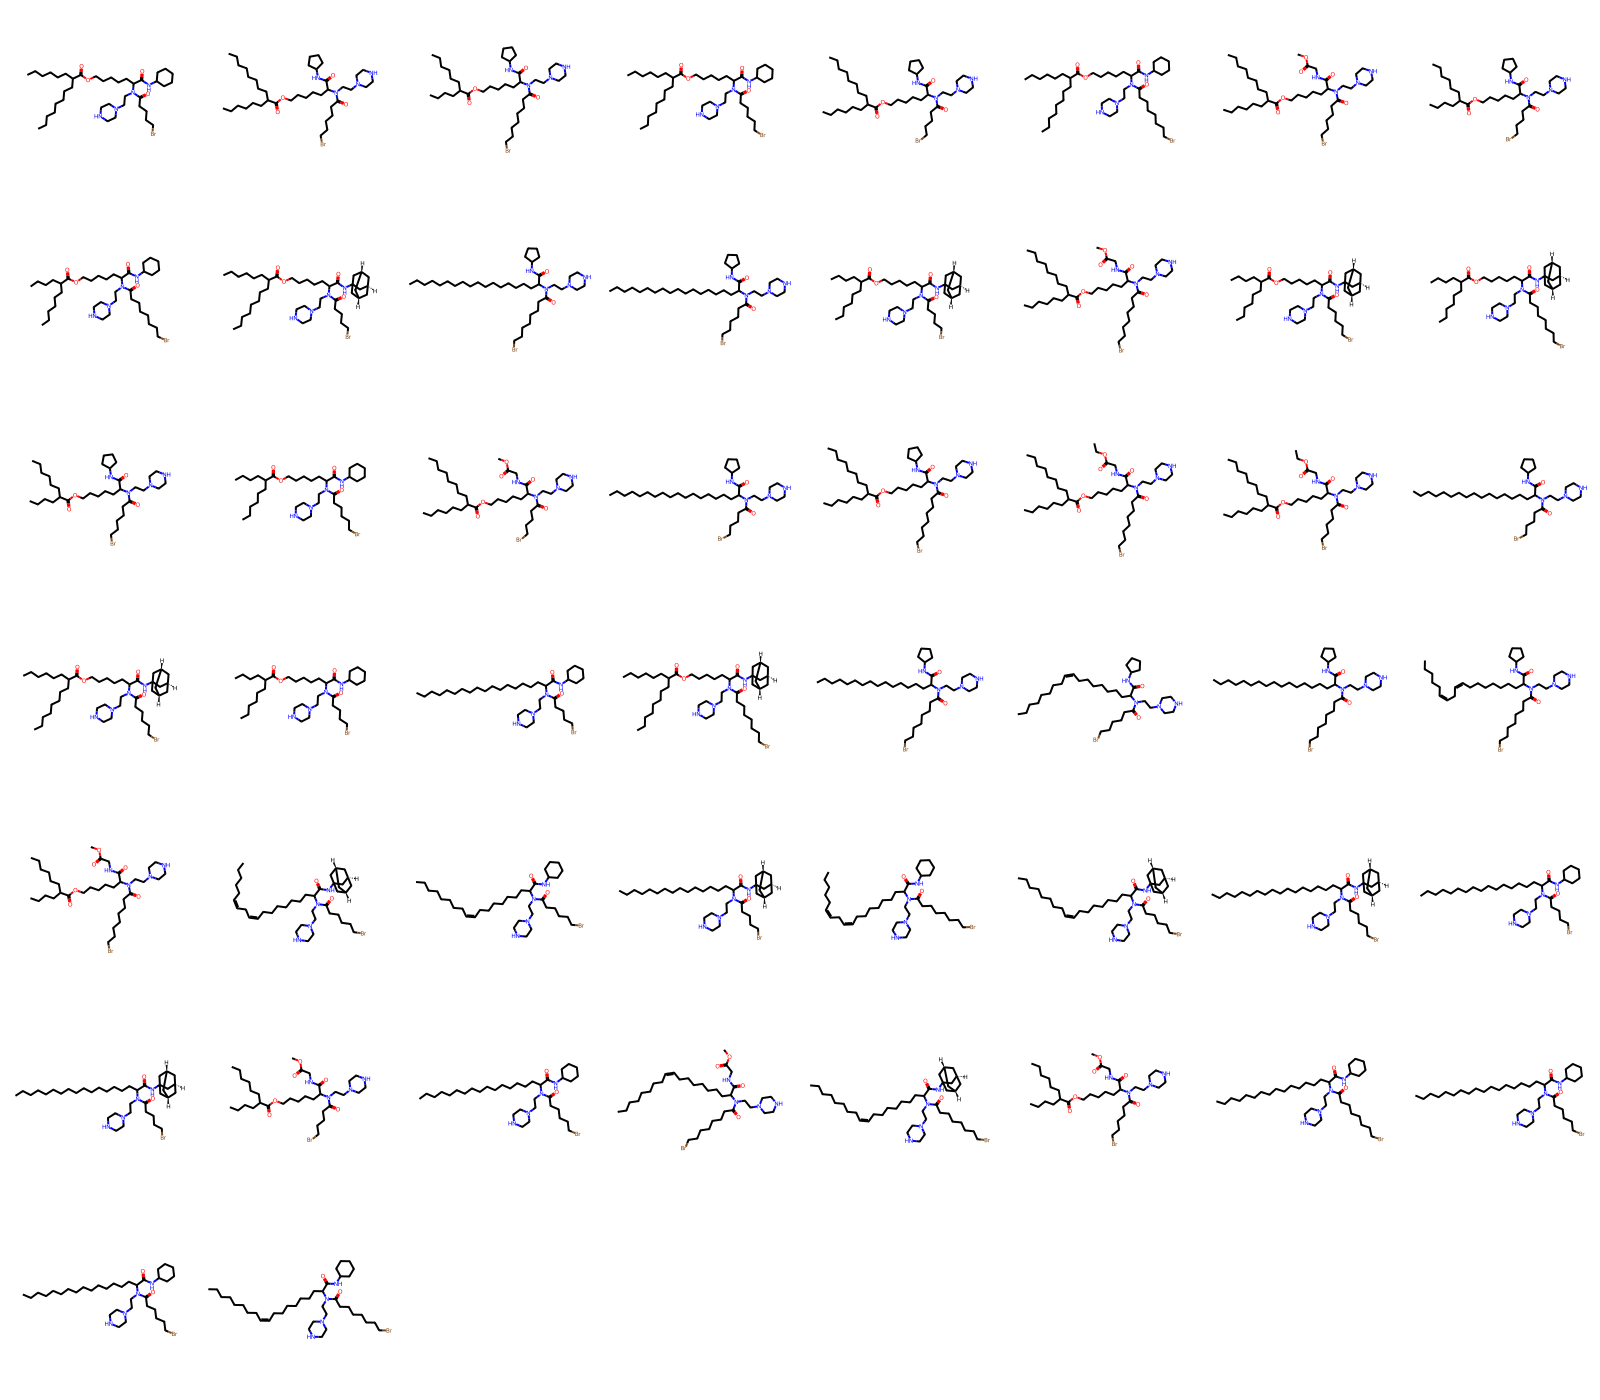

In [6]:
top_96_best = mean_pred_res.mean(axis=1).sort_values(ascending=False).head(96).index

# get structures for the selected points


import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# draw the structures, structures is a list of smiles
mols = [Chem.MolFromSmiles(smi) for smi in top_96_best]

Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200))

In [7]:
_, count_table = count_components(top_96_best)
count_table.head()

reagent_name  count
0                 A0304     86
1  8-bromooctanoic acid     35
2  6-bromohexanoic acid     34
3                 I0824     26
4                 C2959     25

In [8]:
smiles = mean_pred_res.index[3]
components_row = mapping_df[mapping_df["combined_mol_SMILES"] == smiles]
components = [
            components_row["A_name"].values[0],
            components_row["B_name"].values[0],
            components_row["C_name"].values[0],
            components_row["D_name"].values[0],
        ]
components

['D0742', 'T1054', 'H1461', 'U0054']

In [9]:
import plotly.express as px
from collections import Counter

def count_combination(structures):
    res_list = []
    # structures is a list of smiles
    idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
    A = mapping_df.loc[idx, "A_name"]
    B = mapping_df.loc[idx, "B_name"]
    C = mapping_df.loc[idx, "C_name"]
    D = mapping_df.loc[idx, "D_name"]
    
    for a, b, c, d in zip(A, B, C, D):
        res_list.append([a, b, c, d])
    # count table for each unique A or unqiue B or unique C or unique D
    return res_list

def plot_sankey(structures):
    data = count_combination(structures)
    counter = Counter(tuple(x) for x in data)
    df = pd.DataFrame(counter.items(), columns=["combination", "count"])
    df["A"] = df["combination"].apply(lambda x: x[0])
    df["B"] = df["combination"].apply(lambda x: x[1])
    df["C"] = df["combination"].apply(lambda x: x[2])
    df["D"] = df["combination"].apply(lambda x: x[3])


    
    fig = px.parallel_categories(df, dimensions=["A", "B", "C", "D"],)
    return fig
                              

def sampling(n_query, clusters, query_idx):
    sample_res = []
    idx2cluster_mapping = {idx: clusters[idx] for idx in query_idx}  # e.g. {0: c0, 1: c0, 2: c1, 3: c1, ...}
    local_clusters = clusters[query_idx]  # e.g. [c0, c0, c1, c1, ...]
    cluster2size_mapping = {i: np.sum(local_clusters == i) for i in np.unique(local_clusters)}  # e.g. {c0: [0, 1], c1: [2, 3], ...}
    cluster2idx_mapping = {i: [] for i in np.unique(local_clusters)}
    for idx, cluster in idx2cluster_mapping.items():
        cluster2idx_mapping[cluster].append(idx)
    sorted_clusters = sorted(cluster2size_mapping.keys(), 
                             key=lambda x: cluster2size_mapping[x])
    # round robin sampling
    j = 0
    while len(sample_res) < n_query:
        cluster = sorted_clusters[j % len(sorted_clusters)]
        cluster_indices = cluster2idx_mapping[cluster]
        if len(cluster_indices) == 0:
            j += 1
            continue
        selected_idx = np.random.choice(cluster_indices, 1)[0]
        # remove selected index from cluster2idx_mapping
        cluster2idx_mapping[cluster].remove(selected_idx)
        cluster2size_mapping[cluster] -= 1
        sample_res.append(selected_idx)
        print(f"selected_idx: {selected_idx} from cluster {cluster}; cluster size: {cluster2size_mapping[cluster]+1}")
        j += 1
    

    return sample_res


def sampling_with_max_repeat(
    n_query,
    clusters,
    query_idx,
    mapping_df,
    mean_pred_res,
    max_repeat=35,
    existing_component_counts=None,
    smiles_to_skip: Optional[List[str]] = None,
    sample_all_by_idx_order: bool =False,
    sample_first_by_idx_order: bool = False,
):
    """
    Args:
        sample_all_by_idx_order (bool): If True, the samples in each clusster will be selected in the order of query_idx. First in query_idx will be selected first. Useful when the query_idx is already sorted by a predifined metric. However, this may give less diverse samples.
        sample_first_by_idx_order (bool): Only the first sample in each cluster will be selected in the order of query_idx. Useful when the query_idx is already sorted by a predifined metric. However, this may give less diverse samples.
    """
    
    component_counts = {}
    if existing_component_counts is not None:
        component_counts = existing_component_counts

    idx2cluster_mapping = {idx: clusters[idx] for idx in query_idx}
    local_clusters = clusters[query_idx]
    cluster2size_mapping = {
        i: np.sum(local_clusters == i) for i in np.unique(local_clusters)
    }
    cluster2idx_mapping = {i: [] for i in np.unique(local_clusters)}
    for idx, cluster in idx2cluster_mapping.items():
        cluster2idx_mapping[cluster].append(idx)
    # sorted_clusters = sorted(
    #     cluster2size_mapping.keys(), key=lambda x: cluster2size_mapping[x]
    # )
    sorted_clusters = sorted(
        np.unique(local_clusters), key=lambda x: list(local_clusters).index(x)
    )
    
    # round robin sampling
    j = 0
    sample_res = []
    sampled_clusters = {}
    while len(sample_res) < n_query:
        cluster = sorted_clusters[j % len(sorted_clusters)]
        cluster_indices = cluster2idx_mapping[cluster]
        if len(cluster_indices) == 0:
            j += 1
            continue
        if cluster not in sampled_clusters and sample_first_by_idx_order:
            # make sure the first index in the cluster is selected first
            selected_idx = cluster_indices[0]
        else:
            selected_idx = np.random.choice(cluster_indices, 1)[0]

        # get the SMILES string for the selected index
        smiles = mean_pred_res.index[selected_idx]
        # skip if the SMILES is in the list of SMILES to skip
        if smiles_to_skip is not None and smiles in smiles_to_skip:
            cluster2idx_mapping[cluster].remove(selected_idx)
            continue
        # find the components in mapping_df
        components_row = mapping_df[mapping_df["combined_mol_SMILES"] == smiles]
        components = [
            components_row["A_name"].values[0],
            components_row["B_name"].values[0],
            components_row["C_name"].values[0],
            components_row["D_name"].values[0],
        ]
        # check if adding this sample would exceed the max_repeat for any component
        if any(component_counts.get(comp, 0) + 1 > max_repeat for comp in components):
            cluster2idx_mapping[cluster].remove(selected_idx)
            continue
        # update component counts
        for comp in components:
            component_counts[comp] = component_counts.get(comp, 0) + 1
        # remove selected index from cluster2idx_mapping
        cluster2idx_mapping[cluster].remove(selected_idx)
        cluster2size_mapping[cluster] -= 1
        sample_res.append(selected_idx)
        sampled_clusters[cluster] = sampled_clusters.get(cluster, 0) + 1
        print(
            f"selected_idx: {selected_idx} from cluster {cluster}; cluster size: {cluster2size_mapping[cluster]+1}"
        )
        j += 1
    return sample_res, component_counts

In [10]:
plot_sankey(top_96_best)

# step 2

In [11]:
df = mean_embeddings
# to float32
df = df.astype(np.float32)

# NOTE: mapping_df and mean_embeddings have DIFFERENT order


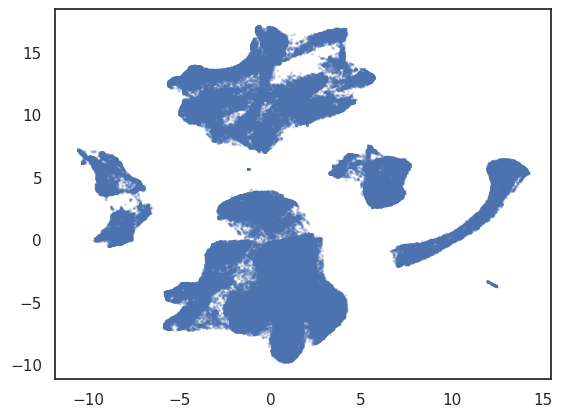

In [12]:
# plot umap and save coordinates
umap_embedding_cache = "/home/sdl/SDL-LNP/model/evaluation/notebooks/umap_coordinates.npy"

if os.path.exists(umap_embedding_cache):
    umap_embedding = np.load(umap_embedding_cache)
else:
    umap = UMAP()
    umap_embedding = umap.fit_transform(df)
    np.save(umap_embedding_cache, umap_embedding)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.2, s=1)


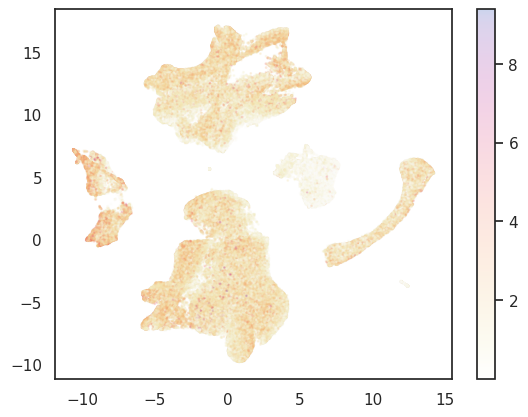

In [13]:
# plot umap

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.2, s=1, 
            c = predictive_variance, cmap=cc.cm.CET_L17,)
# show bar
plt.colorbar()

<Axes: >

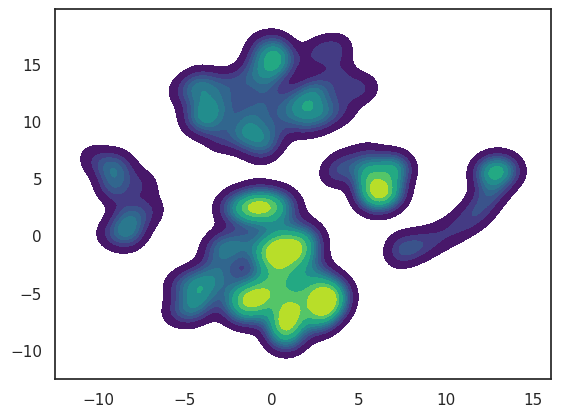

In [14]:
# seaborn kde plot

sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis")

<Axes: >

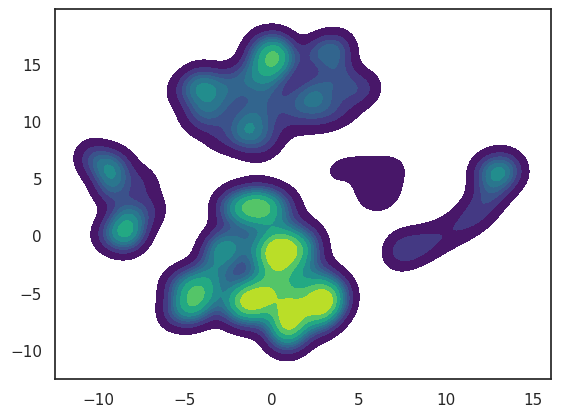

In [15]:
# kde weight by predictive variance

sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis", 
            weights=predictive_variance)

<Axes: >

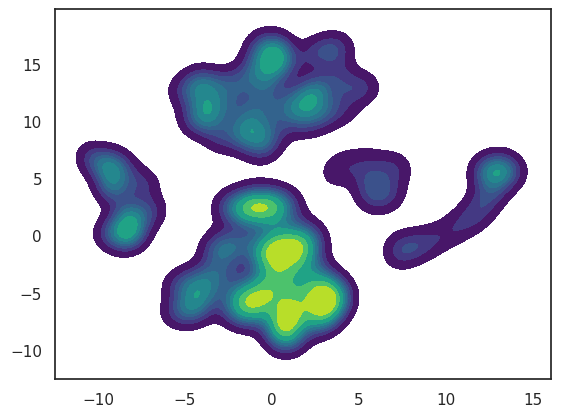

In [16]:
# weight by pred result

agg_pred_res = mean_pred_res.mean(axis=1)  # TODO: the aggregation can be updated, in consideration that the prediction scales can be different

# normalize
agg_pred_res = (agg_pred_res - agg_pred_res.min()) / (agg_pred_res.max() - agg_pred_res.min())
sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis", weights=agg_pred_res)

# step 3

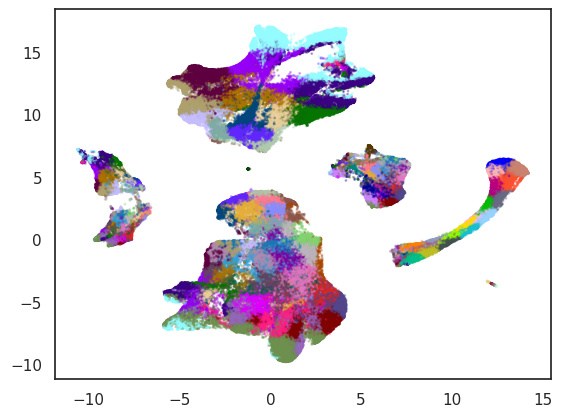

In [17]:
# kmeans clustering with cuml

N = 64

# kmeans = KMeans(n_clusters=N)
# kmeans.fit(df)

kmeans = cuKMeans(n_clusters=N)
kmeans.fit(df)

colors = kmeans.labels_

# map to palette
palette = sns.color_palette(cc.glasbey_hv, n_colors=N )
colors = [palette[i] for i in colors]

# plot kmeans
sns.set_theme(style="white")
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
            color=colors, alpha=0.3, s=1,)

In [18]:
# make sure df and mean_pred_res have the same order of smi_name
assert (df.index == mean_pred_res.index).all()

In [19]:
# get cluster size
cluster_size = np.bincount(kmeans.labels_)
cluster_size

array([ 3832,  1286,  6127, 12048,    51,   764,  9248,  5120,  4603,
        4728,  1646,   981, 13533,    74,     4,  6993,  3759,   699,
         867,  1647,  9847,  5264,    63,  3035,   277,   543, 13625,
         601,  5499,  4803,   468,  1007,  4414,  2463,  7175,  6092,
        5825,  5646,  3397,   408,  3236,  2064,  1055,  4144,   307,
         856,  1423,   520,    36,  6743,  6571,   105,  1254,  3925,
        3001,   370,  7191,  4519,  5704,  2884,   480,   241,  3072,
        3021])

# step 4

In [20]:
# predicted efficacy first sampling
N=10000
query_index = mean_pred_res.mean(axis=1).reset_index().sort_values(ascending=False,by=0).head(N).index
# diversity_sample_idx = sampling(96, kmeans.labels_, query_index)
efficacy_diversity_sample_idx, component_counts = sampling_with_max_repeat(
    92,
    kmeans.labels_,
    query_index,
    mapping_df,
    mean_pred_res,
    max_repeat=30,
    smiles_to_skip=tested_smiles,
    sample_first_by_idx_order=True,
)

selected_idx: 207260 from cluster 42; cluster size: 43
selected_idx: 94971 from cluster 33; cluster size: 112
selected_idx: 111970 from cluster 6; cluster size: 598
selected_idx: 62833 from cluster 37; cluster size: 180
selected_idx: 111981 from cluster 31; cluster size: 46
selected_idx: 114151 from cluster 7; cluster size: 312
selected_idx: 216942 from cluster 46; cluster size: 93
selected_idx: 63722 from cluster 35; cluster size: 565
selected_idx: 84817 from cluster 21; cluster size: 248
selected_idx: 207338 from cluster 12; cluster size: 981
selected_idx: 163769 from cluster 43; cluster size: 141
selected_idx: 111982 from cluster 58; cluster size: 177
selected_idx: 210133 from cluster 53; cluster size: 177
selected_idx: 162169 from cluster 9; cluster size: 161
selected_idx: 206419 from cluster 57; cluster size: 240
selected_idx: 111888 from cluster 3; cluster size: 464
selected_idx: 62783 from cluster 0; cluster size: 184
selected_idx: 82888 from cluster 15; cluster size: 427
select

In [21]:
efficacy_diversity_sampled_df = df.iloc[efficacy_diversity_sample_idx]
structures = efficacy_diversity_sampled_df.index
plot_sankey(structures)

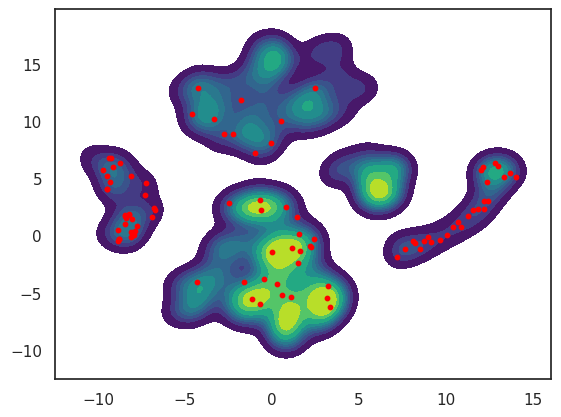

In [22]:
ax = sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis")

# overlay the selected points
ax.scatter(umap_embedding[efficacy_diversity_sample_idx, 0], umap_embedding[efficacy_diversity_sample_idx, 1], s=10, c="red")

In [23]:
predictive_variance = mean_pred_res.var(axis=1)

# variance first sampling, the second plate
N=10000
query_index = predictive_variance.reset_index().sort_values(ascending=False, by=0).head(N).index
existing_component_counts = component_counts.copy()

variance_diversity_sample_idx, component_counts = sampling_with_max_repeat(
    92,
    kmeans.labels_,
    query_index,
    mapping_df,
    mean_pred_res,
    existing_component_counts=component_counts,
    smiles_to_skip=tested_smiles,
)

selected_idx: 112147 from cluster 6; cluster size: 636
selected_idx: 123181 from cluster 28; cluster size: 196
selected_idx: 75000 from cluster 21; cluster size: 162
selected_idx: 2073 from cluster 37; cluster size: 304
selected_idx: 42163 from cluster 26; cluster size: 1576
selected_idx: 186925 from cluster 8; cluster size: 198
selected_idx: 194585 from cluster 32; cluster size: 372
selected_idx: 80032 from cluster 42; cluster size: 54
selected_idx: 204432 from cluster 35; cluster size: 326
selected_idx: 39381 from cluster 3; cluster size: 820
selected_idx: 81504 from cluster 57; cluster size: 134
selected_idx: 43471 from cluster 11; cluster size: 43
selected_idx: 213988 from cluster 9; cluster size: 158
selected_idx: 218810 from cluster 19; cluster size: 69
selected_idx: 107728 from cluster 2; cluster size: 221
selected_idx: 163037 from cluster 20; cluster size: 430
selected_idx: 110273 from cluster 45; cluster size: 51
selected_idx: 35292 from cluster 56; cluster size: 541
selected_

In [24]:
variance_diversity_sampled_df = df.iloc[variance_diversity_sample_idx]

structures = variance_diversity_sampled_df.index
plot_sankey(structures)

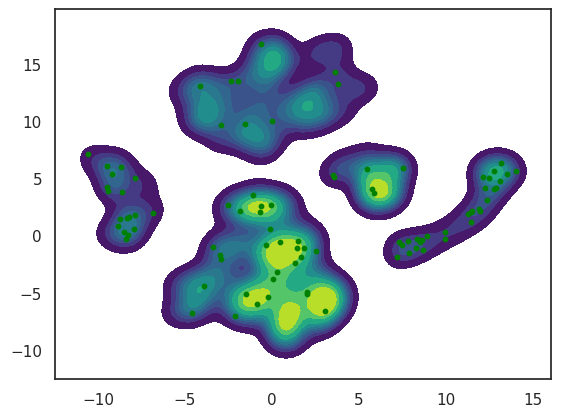

In [25]:
ax = sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis")

# overlay the selected points
ax.scatter(umap_embedding[variance_diversity_sample_idx, 0], umap_embedding[variance_diversity_sample_idx, 1], s=10, c="green")

In [26]:
all_selected_idx = efficacy_diversity_sample_idx + variance_diversity_sample_idx
structures = df.iloc[all_selected_idx].index

fig = plot_sankey(structures)
fig.update_layout(title_text="All Selected Structures")


In [27]:
# get the selected structures in mapping_df
# idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
# structures_df = mapping_df.loc[idx].reset_index(drop=True)
# need to make sure the order keeps the same
idx = []
for smi in structures:
    idx.append(mapping_df[mapping_df["combined_mol_SMILES"] == smi].index[0])
structures_df = mapping_df.loc[idx].reset_index(drop=True)

In [28]:
structures_df

id                                combined_mol_SMILES       A_smiles  \
0     51741  CCCCCCCCCCCCCCCCCC(C(=O)NC1CCCC1)N(CCN(CCN)CCN...   NCCN(CCN)CCN   
1     27413  CCCCCCCC=CC(=O)N(CCN1CCNCC1)C(CCCCCOC(=O)C(CCC...    NCCN1CCNCC1   
2     27368  CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NC12C[C@H]3...    NCCN1CCNCC1   
3     27397  CCCCCCC(CCCC)C(=O)OCCCCCC(C(=O)NC12C[C@H]3C[C@...    NCCN1CCNCC1   
4     27367  CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NC12C[C@H]3...    NCCN1CCNCC1   
..      ...                                                ...            ...   
179  122930  CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CCN1CCCCC1)C(CCC...    NCCN1CCCCC1   
180  178899  CCCCCCC(CCCC)C(=O)OCCCCCC(C(=O)NC(C)(C)C)N(CC1...  NCC1CCN(O)CC1   
181    5903  C=CCCCCCCCCCOC(=O)CCCCC(=O)N(CCN(C)C)C(CCCCCCC...       NCCN(C)C   
182  214210  CCCCCCCC/C=C\CCCCCCCC(C(=O)NC12C[C@H]3C[C@@H](...     NC1=NC=CS1   
183   57590  CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(C(CCCCCCC/C=C\C/...      NN1CCOCC1   

                                         B_smiles  \
0                                [C-]#[N+]C1CCCC1   
1    [C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1   
2    [C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1   
3    [C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1   
4    [C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1   
..                                            ...   
179                                 CCCC[N+]#[C-]   
180                             CC(C)([N+]#[C-])C   
181                             CC(C)([N+]#[C-])C   
182  [C-]#[N+]C1(C[C@@H]2C3)C[C@@H]3C[C@@H](C2)C1   
183                             COC(C[N+]#[C-])=O   

                            C_smiles  \
0               CCCCCCCCCCCCCCCCCC=O   
1        CCCCCCC(CCCC)C(OCCCCCC=O)=O   
2    O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O   
3        CCCCCCC(CCCC)C(OCCCCCC=O)=O   
4    O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O   
..                               ...   
179                    CCCCCCCCCCC=O   
180      CCCCCCC(CCCC)C(OCCCCCC=O)=O   
181                      CCCCCCCCC=O   
182          CCCCCCCC/C=C\CCCCCCCC=O   
183       CCCCC/C=C\C/C=C\CCCCCCCC=O   

                                          D_smiles     A_name  B_name  \
0                                    O=C(O)CCCCCBr      T1243   C2959   
1                               OC(/C=C/CCCCCCC)=O      A0304   I0824   
2                                     O=C(O)CCCCBr      A0304   I0824   
3    OC(C[C@@](C1)(C2)C[C@]3(O)C[C@H]2C[C@H]1C3)=O      A0304   I0824   
4                                 OC(CN(CCO)CCO)=O      A0304   I0824   
..                                             ...        ...     ...   
179                  CCCCC/C=C\C/C=C\CCCCCCCC(O)=O      A1026  133280   
180                              CC(CCC(O)=O)CCCCC  CDS002685   B1274   
181                   OC(CCCCC(OCCCCCCCCCC=C)=O)=O      D5616   B1274   
182                                O=C(O)CCCCCCCBr     123129   I0824   
183                  CCCCC/C=C\C/C=C\CCCCCCCC(O)=O      A0832   M2549   

                   C_name                 D_name  
0                   O0006   6-bromohexanoic acid  
1    2-hexyldecanoic acid                  D0098  
2    2-butyloctanoic acid  5-bromopentanoic acid  
3    2-hexyldecanoic acid                  H1414  
4    2-butyloctanoic acid                  B0484  
..                    ...                    ...  
179                 U0009                  L0124  
180  2-hexyldecanoic acid                  M2380  
181                 N0296            U0047+A0161  
182                 O0058   8-bromooctanoic acid  
183                 O0225                  L0124  

[184 rows x 10 columns]

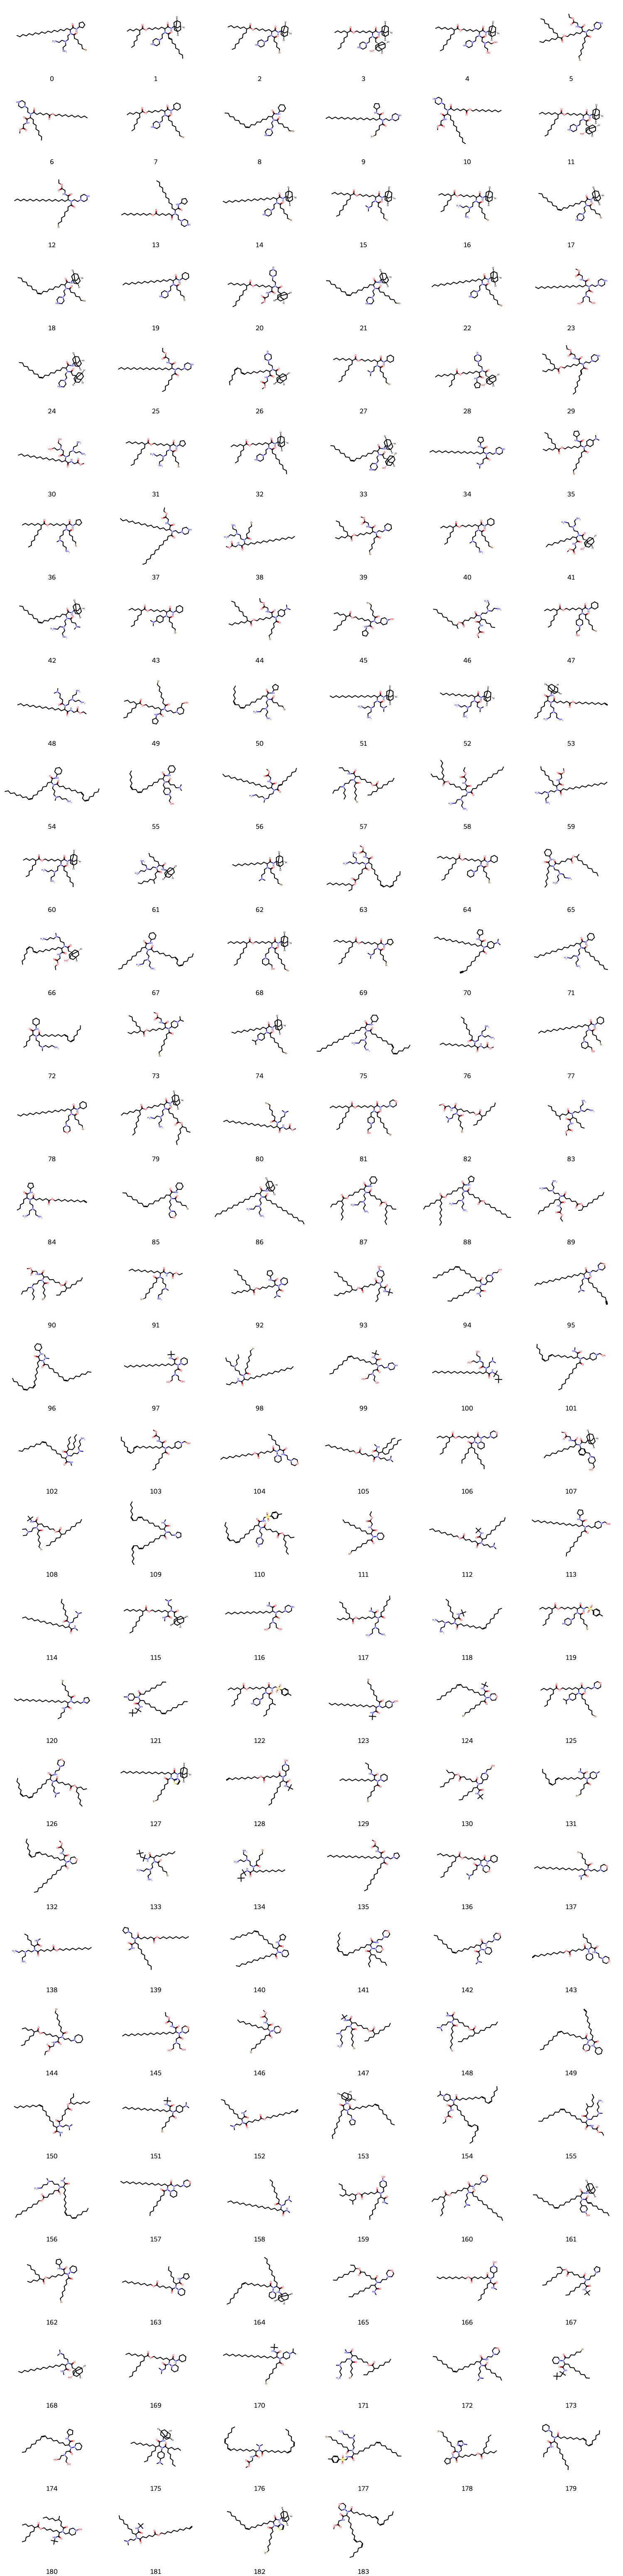

In [29]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

structures = structures_df["combined_mol_SMILES"].values

# draw the structures, structures is a list of smiles
mols = [Chem.MolFromSmiles(smi) for smi in structures]

Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(250, 200), legends=[f"{i}" for i in range(len(mols))], maxMols=len(mols))

In [30]:
structures_df.to_csv("./selected_structures_exp8.csv", index=False)

In [31]:
# next step: run model/active_learning/convert_to_experiment_input.ipynb